# Import libraries

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Bidirectional, Dropout, BatchNormalization, LayerNormalization, Softmax, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from keras.layers import ZeroPadding1D

import gym
from gym import spaces
import gymnasium as gym
from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.noise import NormalActionNoise


from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import time
import multiprocessing
import threading
from collections import deque
import random
from textblob import TextBlob
import csv
import os
import requests
import yfinance as yf
import ta
np.set_printoptions(precision=4, suppress=True)

# Load data

In [ ]:
# Function to get data from the FRED API
def get_fred_data(series_id, api_key):
    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json"
    response = requests.get(url)
    data = response.json()
    return pd.DataFrame(data['observations'])

# Series IDs for the required indicators
series_ids = {
    'Interest Rate': 'FEDFUNDS',
    'Yield Spread': 'T10Y2Y',
    'GDP': 'GDP',
    'Unemployment Rate': 'UNRATE',
    'Inflation Rate': 'CPIAUCSL'
}

# Retrieve data for each series
data_frames = {}
for indicator, series_id in series_ids.items():
    df = get_fred_data(series_id, api_key)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df = df[['value']].astype(float)
    df.columns = [indicator]
    data_frames[indicator] = df

# Combine all data into a DataFrame
combined_df = pd.concat(data_frames.values(), axis=1)

# Filter data
macro_data = combined_df.loc['2018-01-01':'2023-12-31']
macro_data.reset_index(inplace=True)

In [ ]:
# Download data
ticker = '^IXIC'
data = yf.download(ticker, start='2017-01-01', end='2023-12-31')

# Calculate technical indicators
data['EMA_5'] = ta.trend.ema_indicator(data['Close'], window=5)
data['EMA_10'] = ta.trend.ema_indicator(data['Close'], window=10)
data['MACD'] = ta.trend.macd(data['Close'])
data['RSI'] = ta.momentum.rsi(data['Close'])
data['Bollinger_High'] = ta.volatility.bollinger_hband(data['Close'])
data['Bollinger_Low'] = ta.volatility.bollinger_lband(data['Close'])
data['OBV'] = ta.volume.on_balance_volume(data['Close'], data['Volume'])
data['ADX'] = ta.trend.adx(data['High'], data['Low'], data['Close'])
data['MFI'] = ta.volume.money_flow_index(data['High'], data['Low'], data['Close'], data['Volume'])
data['MOM'] = ta.momentum.roc(data['Close'], window=10)
data['SAR'] = ta.trend.psar_up(data['High'], data['Low'], data['Close'])

technical_data = data.drop(columns=['Open','High','Low','Close'], errors='ignore')
technical_data = technical_data.loc['2018-01-01':]
technical_data.reset_index(inplace=True)
technical_data.rename(columns={'Date': 'date'}, inplace=True)

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


In [ ]:
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.1.1 Safari/605.1.15'

def get_news_data(start_date, end_date):
    current_date = start_date
    news_results = []

    while current_date <= end_date:
        headers = {
            "User-Agent": user_agent
        }
        url = f"https://www.google.com/search?q=NASDAQ+after:{current_date.strftime('%Y-%m-%d')}+before:{(current_date + timedelta(days=1)).strftime('%Y-%m-%d')}&gl=us&tbm=nws&num=100"
        print(f"Fetching URL: {url}")
        response = requests.get(url, headers=headers)
        print(f"HTTP Status Code: {response.status_code}")

        if response.status_code == 429:
            print("Too many requests. Sleeping for 60 seconds.")
            time.sleep(60)
            continue

        soup = BeautifulSoup(response.content, "html.parser")

        for el in soup.select("div.SoaBEf"):
            link_tag = el.find("a")
            title_tag = el.select_one("div.MBeuO")
            snippet_tag = el.select_one(".GI74Re")
            date_tag = el.select_one(".LfVVr")
            source_tag = el.select_one(".NUnG9d span")

            if link_tag and title_tag and snippet_tag and date_tag and source_tag:
                link = link_tag["href"]
                title = title_tag.get_text()
                snippet = snippet_tag.get_text()
                date = date_tag.get_text()
                source = source_tag.get_text()

                news_results.append(
                    {
                        "date": date,
                        "title": title,
                        "snippet": snippet,
                        "source": source,
                        "link": link
                    }
                )

        current_date += timedelta(days=1)
        time.sleep(random.uniform(5, 15))

    if not news_results:
        print("No news results found.")

    with open("news_NASDAQ.csv", "w", newline="") as csv_file:
        fieldnames = ["date", "title", "snippet", "source","link"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(news_results)

    print("Data saved to news_data.csv")

if __name__ == "__main__":
    start_date_input = input("Enter start date (YYYY-MM-DD): ")
    end_date_input = input("Enter end date (YYYY-MM-DD): ")

    start_date = datetime.strptime(start_date_input, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_input, "%Y-%m-%d")

    get_news_data(start_date, end_date)


In [ ]:
# Combine all news files in the folder
folder_path = '/content/drive/MyDrive/News NASDAQ/'

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
news = pd.concat([pd.read_csv(os.path.join(folder_path, file)) for file in csv_files])
news = news.sort_values(by='date')

news = news.dropna(subset=['date'])

# Function to calculate sentiment score using TextBlob
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis to the title of each row
news['news_sentiment'] = news['title'].apply(get_sentiment)

# Calculate the average sentiment score by date
news_sentiment = news.groupby('date')['news_sentiment'].mean().reset_index()
news_sentiment.drop_duplicates(subset='date', keep='first', inplace=True)
news_sentiment.date = pd.to_datetime(news_sentiment.date)


In [ ]:
# Merge data
merged_df1 = pd.merge(technical_data, macro_data, on='date', how='left')
data_input = pd.merge(merged_df1, news_sentiment, on='date', how='left')
data_input.to_csv('/content/drive/MyDrive/NASDAQ_combined_data.csv', index=False)


In [87]:
## Load the provided CSV file
file_path = 'NASDAQ_combined_data.csv'
data_input = pd.read_csv(file_path)

adj_close_prices = data_input[['date','Adj Close']].copy()
adj_close_prices.set_index('date', inplace=True)

X=data_input.drop("date", axis=1)

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

validation_size = 0.2

train_size = int(len(scaled_X) * (1-validation_size))
X_train, X_test = pd.DataFrame(scaled_X[0:train_size]), pd.DataFrame(scaled_X[train_size:len(X)])
adj_close_prices_train, adj_close_prices_test = adj_close_prices[0:train_size], adj_close_prices[train_size:len(X)]

# Helper function

In [88]:
# Helper Functions
def plot_trading(ticker, data_input, states_buy, states_sell, profit, episode_number, training = True):
    if not pd.api.types.is_datetime64_any_dtype(data_input.index):
          data_input.index = pd.to_datetime(data_input.index)

    adj_close_prices = data_input['Adj Close']
    day_count = list(range(len(adj_close_prices)))
    dates = data_input.index

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(day_count, adj_close_prices, color='black', lw=1., label='Adjusted Close Price')

    ax.plot(day_count, adj_close_prices, '^', markersize=7, color='m', label='Buying signal', markevery=states_buy)
    ax.plot(day_count, adj_close_prices, 'v', markersize=7, color='b', label='Selling signal', markevery=states_sell)

    if training:
        plt.xlabel('Year')
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.title(f'{ticker} Training episode {episode_number} - Total gains: {profit:.2f}')
        plt.ylabel('Adj Closing Price')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'{ticker} trading_plot_episode_{episode_number}.png')
    else:
        plt.xlabel('Days')
        ax.xaxis.set_major_locator(plt.MultipleLocator(100))
        plt.title(f'{ticker} backtest - Total gains: {profit:.2f}')
        plt.ylabel('Adj Closing Price')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'{ticker} trading_plot_testing.png')

    plt.show()

def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -15, 15)))

def getState(data, t, n):
    if isinstance(data, pd.Series) or isinstance(data, pd.DataFrame):
        data = data.values

    d = t - n + 1
    if d >= 0:
        block = data[d:t + 1]
    else:
        block = np.concatenate((np.full((abs(d), data.shape[1]), data[0]), data[0:t + 1]))

    block = np.array(block)
    if len(block) != n:
        block = np.pad(block, ((0, n - len(block)), (0, 0)), 'edge')

    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))

    return np.array([res])

# Performance Functions
def calculate_cumulative_return(portfolio_values):
    cumulative_return = (portfolio_values[-1] - portfolio_values[0]) / portfolio_values[0]
    return cumulative_return

def calculate_annualized_return(portfolio_values):
    cumulative_return = (portfolio_values[-1] - portfolio_values[0]) / portfolio_values[0]
    num_years = len(portfolio_values) / 252
    annualized_return = (1 + cumulative_return) ** (1 / num_years) - 1
    return annualized_return

def calculate_annualized_std(returns):
    return np.std(returns) * np.sqrt(252)

def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    if len(returns) == 0:
        return 0

    mean_return = np.mean(returns)
    std_dev_return = np.std(returns)

    if std_dev_return == 0:
        return 0

    sharpe_ratio = (mean_return - risk_free_rate / 252) / std_dev_return * np.sqrt(252)

    return sharpe_ratio

def calculate_sortino_ratio(returns, risk_free_rate=0.0):
    downside_returns = returns[returns < 0]
    downside_std = np.std(downside_returns)
    excess_returns = returns - risk_free_rate / 252
    if downside_std == 0:
        return np.inf
    return np.mean(excess_returns) / downside_std * np.sqrt(252)

def calculate_max_drawdown(returns):
    returns = pd.Series(returns)
    if returns.empty or returns.isnull().all() or np.isinf(returns).any():
        raise ValueError("Returns series is empty or contains invalid values.")

    cumulative_returns = (1 + returns).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - running_max) / running_max

    max_drawdown = drawdown.min()
    max_drawdown_end = drawdown.idxmin()

    mask = np.isclose(cumulative_returns[:max_drawdown_end + 1], running_max[max_drawdown_end])
    filtered_series = cumulative_returns[:max_drawdown_end + 1][mask]

    if not filtered_series.empty:
        max_drawdown_start = filtered_series.idxmax()
    else:
        max_drawdown_start = running_max[:max_drawdown_end + 1].idxmax()

    # Calculate the drawdown duration
    if isinstance(returns.index, pd.DatetimeIndex):
        max_drawdown_duration = (max_drawdown_end - max_drawdown_start).days
    else:
        max_drawdown_duration = max_drawdown_end - max_drawdown_start

    return max_drawdown, max_drawdown_duration

# Function to calculate all performance metrics
def calculate_performance_metrics(portfolio_values):
    if len(portfolio_values) == 0:
        raise ValueError("No portfolio values available for performance calculation.")

    returns = np.diff(portfolio_values) / portfolio_values[:-1]

    cumulative_return = calculate_cumulative_return(portfolio_values)
    annualized_return = calculate_annualized_return(portfolio_values)
    annualized_std = calculate_annualized_std(returns)
    sharpe_ratio = calculate_sharpe_ratio(returns)
    sortino_ratio = calculate_sortino_ratio(returns)
    max_drawdown, max_drawdown_length = calculate_max_drawdown(returns)

    print(f"Cumulative Return: {cumulative_return:.4f}")
    print(f"Annualized Return: {annualized_return:.4f}")
    print(f"Annualized Std: {annualized_std:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Sortino Ratio: {sortino_ratio:.4f}")
    print(f"Max Drawdown: {max_drawdown:.4f}")
    print(f"Max Drawdown Length: {max_drawdown_length} days")

    metrics = {
        "cumulative_return": cumulative_return,
        "annualized_return": annualized_return,
        "annualized_std": annualized_std,
        "sharpe_ratio": sharpe_ratio,
        "sortino_ratio": sortino_ratio,
        "max_drawdown": max_drawdown,
        "max_drawdown_length": max_drawdown_length
    }

    return metrics

# Trading Environment

In [97]:
class TradingEnvironment():
    def __init__(self, feature_data, price_data, window_size, initial_cash=100000):

        self.feature_data = feature_data
        self.price_data = price_data
        self.window_size = window_size
        self.initial_cash = initial_cash
        self.current_step = 0
        self.cash = initial_cash
        self.inventory = []
        self.total_profit = 0
        self.portfolio_values = [initial_cash]
        self.portfolio_returns = []
        self.states_sell = []
        self.states_buy = []
        self.done = False

    def reset(self):
        """Reset the environment at the start of each episode."""
        self.current_step = 0
        self.cash = self.initial_cash
        self.inventory = []
        self.total_profit = 0
        self.portfolio_values = [self.initial_cash]
        self.portfolio_returns = []
        self.states_sell = []
        self.states_buy = []
        self.done = False
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        return self._get_state()

    def step(self, action):
        """Execute a buy, sell, or hold action and return next state, reward, and done flag."""
        current_price = self.price_data.iloc[self.current_step]['Adj Close']
        reward = 0
        steps_since_last_trade = 0
        done = False

        print(f"Action: {action}, Cash: {self.cash}, Inventory: {len(self.inventory)}")

        # Action logic
        if action == 1:  # Buy
            if self.cash >= current_price:
                self.inventory.append(current_price)
                self.cash -= current_price
                self.states_buy.append(self.current_step)
                reward = 0
                print(f"Buy: {formatPrice(current_price)}")
            else:
                print(f"Buy action skipped due to insufficient cash: {self.cash}")
                reward = -0.005

        elif action == 2: # Sell
            if len(self.inventory) > 0:
                bought_price = self.inventory.pop(0)
                profit = current_price - bought_price
                self.total_profit += profit
                self.cash += current_price
                self.states_sell.append(self.current_step)
                portfolio_return = (current_price - bought_price) / bought_price
                self.portfolio_returns.append(portfolio_return)
                reward = portfolio_return
                #reward = max(portfolio_return, 0)
                print(f"Sell: {formatPrice(current_price)} with profit: {formatPrice(profit)}")
            else:
                reward = -0.005  # Penalty if trying to sell without inventory

        else:  # Hold
            #If holding, check if the price increased or decreased
            if self.current_step > 0:
                previous_price = self.price_data.iloc[self.current_step - 1]['Adj Close']
                price_change = current_price - previous_price

                if len(self.inventory) > 0:  # Holding with a position
                    if price_change > 0:
                        reward = 0.005  # Reward for holding when prices are increasing
                    else:
                        reward = -0.005  # Small penalty for holding during a price drop
                else:  # Holding without a position (waiting for a better entry point)
                    if price_change < 0:
                        reward = 0.002  # Small reward for holding when prices are dropping (avoiding bad entry)
                    else:
                        reward = -0.005  # Small penalty for not taking action during an uptrend
            else:
                reward = -0.005  # Default penalty for holding on the first step


        print(f"End of day inventory: {len(self.inventory)}")

        # Update step count and check if done
        self.current_step += 1
        if self.current_step >= len(self.feature_data) - 1:
            done = True

        # Update portfolio value (cash + value of stocks held)
        current_value = self.cash + len(self.inventory) * current_price
        self.portfolio_values.append(current_value)

        # Return next state, reward, and done flag
        next_state = self._get_state()
        return next_state, reward, done

    def _get_state(self):
        """Return a window of the past features as the state."""
        return getState(self.feature_data, self.current_step, self.window_size + 1)


# A3C agent

In [89]:
class A3CAgent:
    def __init__(self, state_size, num_features, action_size=3, initial_cash=100000, is_eval=False):
        self.state_size = state_size
        self.num_features = num_features
        self.action_size = action_size
        self.gamma = 0.95
        self.initial_cash = initial_cash
        self.inventory = []
        self.is_eval = is_eval
        self.entropy_coeff = 0.5
        self.step_count = 0

        # Set epsilon to 1 during training, 0 during testing
        self.epsilon = 1.0 if not is_eval else 0.0
        self.epsilon_decay = 0.9995
        self.epsilon_min = 0.05

        # Hyperparameters for Actor Critic models
        self.actor_learning_rate = 0.001
        self.critic_learning_rate = 0.001

        # Initialize models for actor and critic
        self.actor_model = self._build_actor_model()
        self.critic_model = self._build_critic_model()

        # Optimizers for the actor and critic
        self.actor_optimizer = Adam(learning_rate=self.actor_learning_rate)
        self.critic_optimizer = Adam(learning_rate=self.critic_learning_rate)

        # Early stopping callbacks
        self.early_stopping_actor = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
        self.early_stopping_critic = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

    def _build_actor_model(self):
        input_layer = Input(shape=(self.state_size, self.num_features))

        padded_inputs = ZeroPadding1D(padding=1)(input_layer)

        # Conv1D layer to extract features from the input sequence
        conv1 = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.05))(padded_inputs)
        conv1 = BatchNormalization()(conv1)
        conv1 = Dropout(0.5)(conv1)

        conv2 = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.05))(conv1)
        conv2 = BatchNormalization()(conv2)
        conv2 = Dropout(0.5)(conv2)

        conv3 = Conv1D(filters=128, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.05))(conv2)
        conv3 = BatchNormalization()(conv3)
        conv3 = Dropout(0.5)(conv3)

        # MaxPooling to reduce the dimensionality
        pool2 = MaxPooling1D(pool_size=2)(conv3)

        # Bi-LSTM to capture long-term dependencies from the Conv1D output
        bi_lstm = Bidirectional(LSTM(units=128, return_sequences=False, kernel_regularizer=l2(0.05), stateful=False))(pool2)
        bi_lstm = LayerNormalization()(bi_lstm)
        bi_lstm = Dropout(0.5)(bi_lstm)

        # Dense layer after Bi-LSTM
        dense1 = Dense(units=32, activation="relu", kernel_regularizer=l2(0.05))(bi_lstm)
        dense1 = Dropout(0.5)(dense1)

        # Output layer with softmax for 3 actions
        output_layer = Dense(self.action_size, activation="softmax")(dense1)

        # Compile the model
        model = Model(inputs=input_layer, outputs=output_layer)
        return model

    def _build_critic_model(self):
        input_layer = Input(shape=(self.state_size, self.num_features))

        # Conv1D layers for local feature extraction
        conv1 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same', kernel_regularizer=l2(0.05))(input_layer)
        conv1 = BatchNormalization()(conv1)
        conv1 = Dropout(0.5)(conv1)

        conv2 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same', kernel_regularizer=l2(0.05))(conv1)
        conv2 = BatchNormalization()(conv2)
        conv2 = Dropout(0.5)(conv2)

        conv3 = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same', kernel_regularizer=l2(0.05))(conv2)
        conv3 = BatchNormalization()(conv3)
        conv3 = Dropout(0.5)(conv3)

        # MaxPooling to reduce the dimensionality
        pool2 = MaxPooling1D(pool_size=2)(conv3)

        # Bi-LSTM for capturing temporal dependencies in the time series
        bi_lstm = Bidirectional(LSTM(units=128, return_sequences=False, kernel_regularizer=l2(0.05), stateful=False))(pool2)
        bi_lstm = LayerNormalization()(bi_lstm)
        bi_lstm = Dropout(0.5)(bi_lstm)

        # Dense layer after Bi-LSTM
        dense1 = Dense(units=32, activation="relu", kernel_regularizer=l2(0.05))(bi_lstm)
        dense1 = Dropout(0.5)(dense1)

        # Output layer for predicting the value of the state
        output_layer = Dense(1, activation="linear")(dense1)

        model = Model(inputs=input_layer, outputs=output_layer)

        return model

    def act(self, state):
        state = np.reshape(state, (1, self.state_size, self.num_features))

        # During training, use epsilon-greedy exploration
        if not self.is_eval and np.random.rand() <= self.epsilon:
          action = np.random.choice(self.action_size)
          return action

        action_probs = self.actor_model(state, training=False).numpy()

        # Exploration: Choose action probabilistically during training
        if not self.is_eval:
            action = np.random.choice(self.action_size, p=action_probs[0])
        else:
            # Exploitation: During testing, choose the action with the highest probability
            action = np.argmax(action_probs[0])

        return action

    def compute_advantage(self, reward, value, next_value, done):
        if done:
            return reward - value
        else:
            return reward + self.gamma * next_value - value


    def train(self, state, action, reward, next_state, done, critic_update_interval=5):
        current_cash = state[0, -1, 0]
        next_cash = next_state[0, -1, 0]

        if action == 1:  # Buy action
            if current_cash >= next_cash:
                reward += 0
            else:
                reward += -0.005

        elif action == 2:  # Sell action
            if len(self.inventory) > 0:
                last_bought_price = self.inventory[-1]
                sell_price = next_state[0, -1, 0]
                profit = sell_price - last_bought_price
                if profit > 0:
                    reward += 0.005
                else:
                    reward += -0.005

        elif action == 0:  # Hold action
            # Dynamic penalty or reward for holding based on market conditions
            previous_price = state[0, -1, 0]
            current_price = next_state[0, -1, 0]
            price_change = current_price - previous_price

            if price_change > 0:
                reward += -0.005  # Penalize holding when the market is rising
            elif price_change < 0:
                reward += 0.005  # Reward holding if the market was falling

        with tf.GradientTape() as tape_actor, tf.GradientTape() as tape_critic:
            # Critic: Get the value of the current state and next state
            value = self.critic_model(state, training=True)
            next_value = self.critic_model(next_state, training=True)

            # Compute the advantage
            advantage = self.compute_advantage(reward, value, next_value, done)

            # Critic Loss
            critic_loss = tf.reduce_mean(tf.square(advantage))
            print(f"Critic Loss: {critic_loss}")

            # Actor Loss
            action_probs = self.actor_model(state, training=True)
            print("action_probs in train function: ", action_probs)
            log_prob = tf.math.log(action_probs[0, action])
            actor_loss = -log_prob * advantage

            # Add entropy regularization to encourage exploration
            entropy = -tf.reduce_sum(action_probs * tf.math.log(action_probs + 1e-10))
            actor_loss -= self.entropy_coeff * entropy

        # Apply gradients for the model
        actor_grads = tape_actor.gradient(actor_loss, self.actor_model.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor_model.trainable_variables))

        critic_grads = tape_critic.gradient(critic_loss, self.critic_model.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic_model.trainable_variables))

        self.step_count += 1
        self.decay_epsilon()

    def reset(self):
        self.epsilon = 0.0 if self.is_eval else 1.0

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [90]:
class A3CAgentGlobal(A3CAgent):
    def __init__(self, state_size, num_features, action_size=3, initial_cash=100000):
        super().__init__(state_size, num_features, action_size, initial_cash, is_eval=False)

    def synchronize_weights(self, local_actor_model, local_critic_model, lock):
        with lock:
            global_actor_weights = self.actor_model.get_weights()
            local_actor_weights = local_actor_model.get_weights()

            updated_actor_weights = [(global_w + local_w) / 2 for global_w, local_w in zip(global_actor_weights, local_actor_weights)]
            self.actor_model.set_weights(updated_actor_weights)

            global_critic_weights = self.critic_model.get_weights()
            local_critic_weights = local_critic_model.get_weights()

            updated_critic_weights = [(global_w + local_w) / 2 for global_w, local_w in zip(global_critic_weights, local_critic_weights)]
            self.critic_model.set_weights(updated_critic_weights)

    def update_global_model(self, local_agent, lock):
        with lock:
            self.actor_model.set_weights(local_agent.actor_model.get_weights())
            self.critic_model.set_weights(local_agent.critic_model.get_weights())

    def get_global_weights(self):
        return self.actor_model.get_weights(), self.critic_model.get_weights()

    def set_global_weights(self, actor_weights, critic_weights):
        self.actor_model.set_weights(actor_weights)
        self.critic_model.set_weights(critic_weights)


In [93]:
# A3C Worker Class
class A3CWorker(multiprocessing.Process):
    def __init__(self, worker_id, global_agent, env, lock, num_episodes):
        super(A3CWorker, self).__init__()
        self.worker_id = worker_id
        self.global_agent = global_agent
        self.local_agent = A3CAgent(window_size, num_features, is_eval=False)
        self.env = env
        self.lock = lock
        self.num_episodes = num_episodes

        self.local_agent.actor_model.set_weights(self.global_agent.actor_model.get_weights())
        self.local_agent.critic_model.set_weights(self.global_agent.critic_model.get_weights())

    def run(self):
        print(f"Worker {self.worker_id} started.")

        for episode in range(self.num_episodes):
            print(f"Worker {self.worker_id}, Running Episode {episode + 1}/{self.num_episodes}")
            state = self.env.reset()

            t = 0
            done = False
            while not done:
                action = self.local_agent.act(state)
                next_state, reward, done = self.env.step(action)

                # Train the local agent
                self.local_agent.train(state, action, reward, next_state, done)
                state = next_state
                t += 1

                self.local_agent.decay_epsilon()

                if done:
                    print(f"Worker {self.worker_id}, Episode {episode + 1}/{self.num_episodes} - Total Profit: {self.env.total_profit}")
                    print(f"Total buy actions: {len(self.env.states_buy)}, Total sell actions: {len(self.env.states_sell)}")
                    with self.lock:
                        self.global_agent.actor_model.set_weights(self.local_agent.actor_model.get_weights())
                        self.global_agent.critic_model.set_weights(self.local_agent.critic_model.get_weights())

                    break


In [101]:
# Function to run workers in parallel
def run_parallel_workers(num_workers, num_episodes, global_agent, X_train, adj_close_prices_train, window_size, initial_cash):
    ctx = multiprocessing.get_context('spawn')
    lock = multiprocessing.Lock()

    workers = []
    for worker_id in range(num_workers):
        print(f"Initializing Worker {worker_id}")
        worker_env = TradingEnvironment(X_train, adj_close_prices_train, window_size, initial_cash)

        worker = ctx.Process(target=run_worker, args=(worker_id, global_agent, worker_env, lock, num_episodes))
        workers.append(worker)

    for worker in workers:
        print(f"Starting Worker {worker.name}")
        worker.start()
        print(f"Worker {worker.name} finished.")

    for worker in workers:
        worker.join()

def run_worker(worker_id, global_agent, env, lock, num_episodes):
    print(f"Worker {worker_id} starting.")
    local_agent = A3CAgent(window_size, num_features, is_eval=False)

    local_agent.actor_model.set_weights(global_agent.actor_model.get_weights())
    local_agent.critic_model.set_weights(global_agent.critic_model.get_weights())

    for episode in range(num_episodes):
        state = env.reset()

        total_reward = 0
        t = 0
        done = False
        while not done:
            action = local_agent.act(state)
            next_state, reward, done = env.step(action)

            # Train the local agent
            local_agent.train(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            t += 1

            local_agent.decay_epsilon()

            if done:
                print(f"Worker {worker_id}, Episode {episode + 1}/{num_episodes} - Total Profit: {env.total_profit}")
                print(f"Total buy actions: {len(env.states_buy)}, Total sell actions: {len(env.states_sell)}")

                # Update global models with local models' weights
                with lock:
                    print(f"Worker {worker_id} updating global model weights.")
                    global_agent.actor_model.set_weights(local_agent.actor_model.get_weights())
                    global_agent.critic_model.set_weights(local_agent.critic_model.get_weights())
                break

In [ ]:
# Initialize parameters
num_workers = 4
num_episodes = 30
window_size = 10
num_features = len(X_train.columns)

# Create the global A3C agent
global_agent = A3CAgentGlobal(window_size, num_features)

# Run parallel workers for training
run_parallel_workers(num_workers, num_episodes, global_agent, X_train, adj_close_prices_train, window_size, initial_cash=100000)

# Save the final global models
global_agent.actor_model.save("actor_model.keras")
global_agent.critic_model.save("critic_model.keras")

# Testing - NASDAQ

In [18]:
def test_a3c_agent(agent, test_env):
    state = test_env.reset()
    total_profit = 0

    for t in range(len(X_test) - 1):
        state = np.reshape(state, (1, agent.state_size, agent.num_features))

        action = agent.act(state)
        next_state, reward, done = test_env.step(action)
        print(f"Day {t}, Action: {action}, inventory(t-1): {len(test_env.inventory)}")
        print(f"Action probabilities at step {t}: {agent.actor_model(state)[0]}")

        # Move to the next state
        state = next_state
        print()

        if done:
            print(f"Total Profit from test data: {formatPrice(test_env.total_profit)}")
            print(f"Total buy actions: {len(test_env.states_buy)}, Total sell actions: {len(test_env.states_sell)}")
            plot_trading(ticker,
                         data_input=adj_close_prices_test,
                         states_buy=test_env.states_buy,
                         states_sell=test_env.states_sell,
                         profit=test_env.total_profit,
                         episode_number='test',
                         training = False)
            break

Exploitation: Action probabilities in act function: [[0.3935 0.3406 0.2659]]
Action: 0, Cash: 100000, Inventory: 0
End of day inventory: 0
Day 0, Action: 0, inventory(t-1): 0
Action probabilities at step 0: [0.3935 0.3406 0.2659]

Exploitation: Action probabilities in act function: [[0.4968 0.3619 0.1412]]
Action: 0, Cash: 100000, Inventory: 0
End of day inventory: 0
Day 1, Action: 0, inventory(t-1): 0
Action probabilities at step 1: [0.4968 0.3619 0.1412]

Exploitation: Action probabilities in act function: [[0.3956 0.3077 0.2967]]
Action: 0, Cash: 100000, Inventory: 0
End of day inventory: 0
Day 2, Action: 0, inventory(t-1): 0
Action probabilities at step 2: [0.3956 0.3077 0.2967]

Exploitation: Action probabilities in act function: [[0.4238 0.3498 0.2264]]
Action: 0, Cash: 100000, Inventory: 0
End of day inventory: 0
Day 3, Action: 0, inventory(t-1): 0
Action probabilities at step 3: [0.4238 0.3498 0.2264]

Exploitation: Action probabilities in act function: [[0.2749 0.4012 0.3239]]

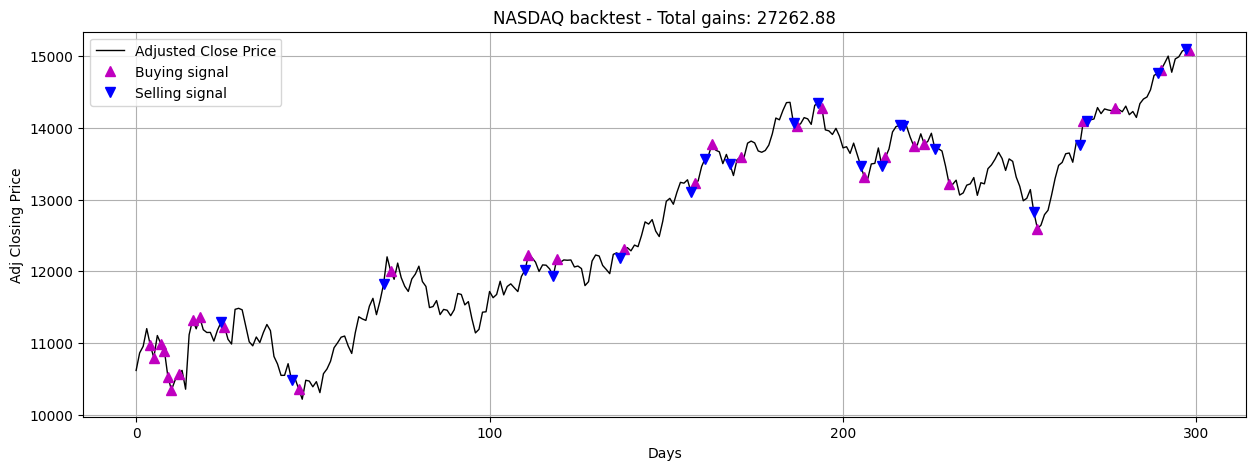

Cumulative Return: 0.3790
Annualized Return: 0.3099
Annualized Std: 0.1814
Sharpe Ratio: 1.5840
Sortino Ratio: 2.7722
Max Drawdown: -0.1110
Max Drawdown Length: 70 days


In [ ]:
# NASDAQ with sentiment
window_size = 10
ticker = "NASDAQ"

# Testing environment instantiation
test_env = TradingEnvironment(X_test, adj_close_prices_test, window_size, initial_cash=100000)

# Clear the session to prevent carryover
K.clear_session()

# Instantiate the A3C agent for testing
a3c_agent_test = A3CAgent(window_size, len(X_test.columns), is_eval=True)

# Load the saved model to ensure proper weight initialization
a3c_agent_test.actor_model = load_model(f"actor_model.keras")
a3c_agent_test.critic_model = load_model(f"critic_model.keras")

# Reset the agent before testing to ensure no carryover of state from training
a3c_agent_test.reset()

# Perform testing
test_sharpe_ratio = test_a3c_agent(a3c_agent_test, test_env)
calculate_performance_metrics(test_env.portfolio_values)
pd.DataFrame(test_env.portfolio_values).to_csv('NASDAQ A3C sentiment.csv', index=False)

Exploitation: Action probabilities in act function: [[0.3935 0.3406 0.2659]]
Action: 0, Cash: 100000, Inventory: 0
End of day inventory: 0
Day 0, Action: 0, inventory(t-1): 0
Action probabilities at step 0: [0.3935 0.3406 0.2659]

Exploitation: Action probabilities in act function: [[0.4969 0.3619 0.1412]]
Action: 0, Cash: 100000, Inventory: 0
End of day inventory: 0
Day 1, Action: 0, inventory(t-1): 0
Action probabilities at step 1: [0.4969 0.3619 0.1412]

Exploitation: Action probabilities in act function: [[0.3955 0.3078 0.2966]]
Action: 0, Cash: 100000, Inventory: 0
End of day inventory: 0
Day 2, Action: 0, inventory(t-1): 0
Action probabilities at step 2: [0.3955 0.3078 0.2966]

Exploitation: Action probabilities in act function: [[0.4239 0.3496 0.2265]]
Action: 0, Cash: 100000, Inventory: 0
End of day inventory: 0
Day 3, Action: 0, inventory(t-1): 0
Action probabilities at step 3: [0.4239 0.3496 0.2265]

Exploitation: Action probabilities in act function: [[0.275  0.4011 0.324 ]]

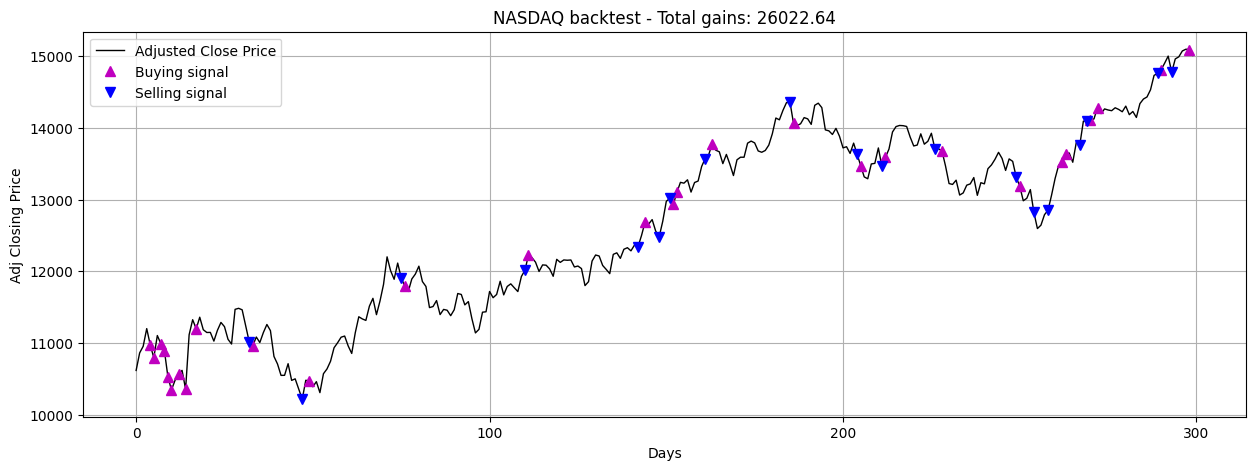

Cumulative Return: 0.3596
Annualized Return: 0.2944
Annualized Std: 0.1824
Sharpe Ratio: 1.5108
Sortino Ratio: 2.6687
Max Drawdown: -0.1167
Max Drawdown Length: 62 days


In [ ]:
# NASDAQ without sentiment
window_size = 10
ticker = "NASDAQ"

# Testing environment instantiation
test_env = TradingEnvironment(X_test, adj_close_prices_test, window_size, initial_cash=100000)

# Clear the session to prevent carryover
K.clear_session()

# Instantiate the A3C agent for testing
a3c_agent_test = A3CAgent(window_size, len(X_test.columns), is_eval=True)

# Load the saved model to ensure proper weight initialization
a3c_agent_test.actor_model = load_model(f"actor_model.keras")
a3c_agent_test.critic_model = load_model(f"critic_model.keras")

# Reset the agent before testing to ensure no carryover of state from training
a3c_agent_test.reset()

# Perform testing
test_sharpe_ratio = test_a3c_agent(a3c_agent_test, test_env)
calculate_performance_metrics(test_env.portfolio_values)
pd.DataFrame(test_env.portfolio_values).to_csv('NASDAQ A3C no sentiment.csv', index=False)

# Testing DJIA

Exploitation: Action probabilities in act function: [[0.3935 0.3406 0.2659]]
Action: 0, Cash: 200000, Inventory: 0
End of day inventory: 0
Day 0, Action: 0, inventory(t-1): 0
Action probabilities at step 0: [0.3935 0.3406 0.2659]

Exploitation: Action probabilities in act function: [[0.514  0.3127 0.1733]]
Action: 0, Cash: 200000, Inventory: 0
End of day inventory: 0
Day 1, Action: 0, inventory(t-1): 0
Action probabilities at step 1: [0.514  0.3127 0.1733]

Exploitation: Action probabilities in act function: [[0.4635 0.3392 0.1973]]
Action: 0, Cash: 200000, Inventory: 0
End of day inventory: 0
Day 2, Action: 0, inventory(t-1): 0
Action probabilities at step 2: [0.4635 0.3392 0.1973]

Exploitation: Action probabilities in act function: [[0.5266 0.3117 0.1617]]
Action: 0, Cash: 200000, Inventory: 0
End of day inventory: 0
Day 3, Action: 0, inventory(t-1): 0
Action probabilities at step 3: [0.5266 0.3117 0.1617]

Exploitation: Action probabilities in act function: [[0.5537 0.2846 0.1617]]

<ipython-input-9-c33cb9aefdd3>:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_input.index = pd.to_datetime(data_input.index)


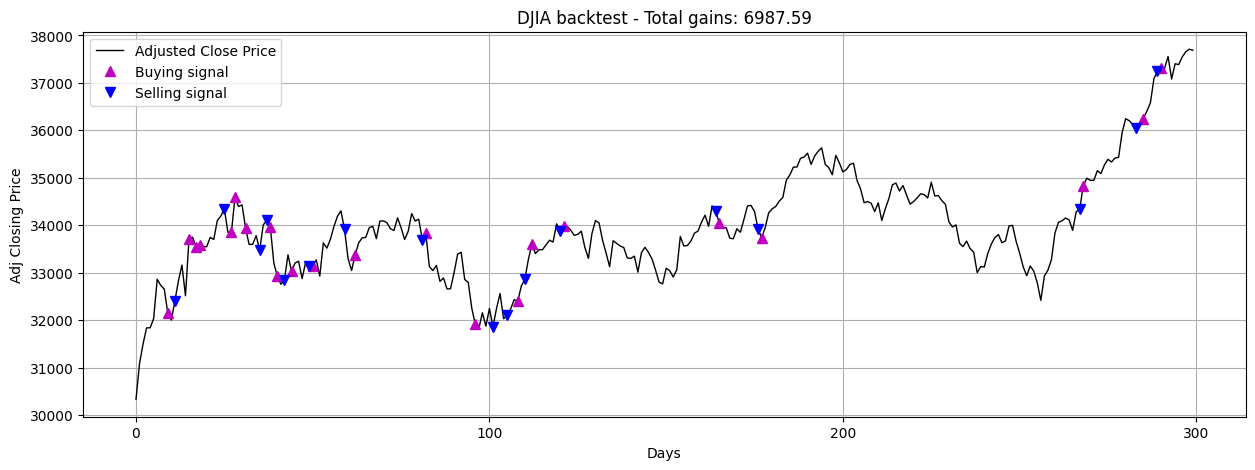

Cumulative Return: 0.0968
Annualized Return: 0.0807
Annualized Std: 0.0928
Sharpe Ratio: 0.8863
Sortino Ratio: 1.3917
Max Drawdown: -0.0766
Max Drawdown Length: 62 days


In [ ]:
# DJIA with sentiment
window_size = 10
ticker = "DJIA"

# Testing environment instantiation
test_env = TradingEnvironment(X_test, adj_close_prices_test, window_size, initial_cash=200000)

# Clear the session to prevent carryover
K.clear_session()

# Instantiate the A3C agent for testing
a3c_agent_test = A3CAgent(window_size, len(X_test.columns), is_eval=True)

# Load the saved model to ensure proper weight initialization
a3c_agent_test.actor_model = load_model(f"actor_model.keras")
a3c_agent_test.critic_model = load_model(f"critic_model.keras")

# Reset the agent before testing to ensure no carryover of state from training
a3c_agent_test.reset()

# Perform testing
test_sharpe_ratio = test_a3c_agent(a3c_agent_test, test_env)
calculate_performance_metrics(test_env.portfolio_values)
pd.DataFrame(test_env.portfolio_values).to_csv('DJIA A3C sentiment.csv', index=False)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/rnn.py", line 418, in <genexpr>
    output_ta_t = tuple(  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


Exploitation: Action probabilities in act function: [[0.3935 0.3406 0.2659]]
Action: 0, Cash: 200000, Inventory: 0
End of day inventory: 0
Day 0, Action: 0, inventory(t-1): 0
Action probabilities at step 0: [0.3935 0.3406 0.2659]

Exploitation: Action probabilities in act function: [[0.4722 0.3811 0.1467]]
Action: 0, Cash: 200000, Inventory: 0
End of day inventory: 0
Day 1, Action: 0, inventory(t-1): 0
Action probabilities at step 1: [0.4722 0.3811 0.1467]

Exploitation: Action probabilities in act function: [[0.3758 0.3682 0.2559]]
Action: 0, Cash: 200000, Inventory: 0
End of day inventory: 0
Day 2, Action: 0, inventory(t-1): 0
Action probabilities at step 2: [0.3758 0.3682 0.2559]

Exploitation: Action probabilities in act function: [[0.3886 0.3425 0.269 ]]
Action: 0, Cash: 200000, Inventory: 0
End of day inventory: 0
Day 3, Action: 0, inventory(t-1): 0
Action probabilities at step 3: [0.3886 0.3425 0.269 ]

Exploitation: Action probabilities in act function: [[0.3339 0.392  0.2742]]

<ipython-input-9-c33cb9aefdd3>:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_input.index = pd.to_datetime(data_input.index)


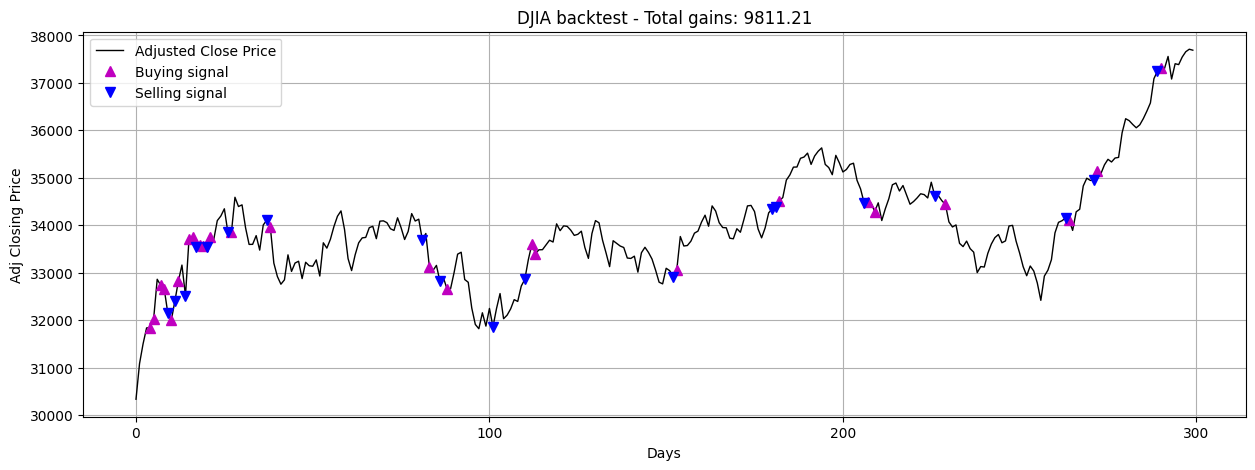

Cumulative Return: 0.1314
Annualized Return: 0.1092
Annualized Std: 0.1147
Sharpe Ratio: 0.9645
Sortino Ratio: 1.5464
Max Drawdown: -0.0837
Max Drawdown Length: 62 days


In [ ]:
# DJIA without sentiment
window_size = 10
ticker = "DJIA"

# Testing environment instantiation
test_env = TradingEnvironment(X_test, adj_close_prices_test, window_size, initial_cash=200000)

# Clear the session to prevent carryover
K.clear_session()

# Instantiate the A3C agent for testing
a3c_agent_test = A3CAgent(window_size, len(X_test.columns), is_eval=True)

# Load the saved model to ensure proper weight initialization
a3c_agent_test.actor_model = load_model(f"actor_model.keras")
a3c_agent_test.critic_model = load_model(f"critic_model.keras")

# Reset the agent before testing to ensure no carryover of state from training
a3c_agent_test.reset()

# Perform testing
test_sharpe_ratio = test_a3c_agent(a3c_agent_test, test_env)
calculate_performance_metrics(test_env.portfolio_values)
pd.DataFrame(test_env.portfolio_values).to_csv('DJIA A3C no sentiment.csv', index=False)

# Testing S&P 500

Exploitation: Action probabilities in act function: [[0.3935 0.3406 0.2659]]
Action: 0, Cash: 100000, Inventory: 0
End of day inventory: 0
Day 0, Action: 0, inventory(t-1): 0
Action probabilities at step 0: [0.3935 0.3406 0.2659]

Exploitation: Action probabilities in act function: [[0.4847 0.372  0.1433]]
Action: 0, Cash: 100000, Inventory: 0
End of day inventory: 0
Day 1, Action: 0, inventory(t-1): 0
Action probabilities at step 1: [0.4847 0.372  0.1433]

Exploitation: Action probabilities in act function: [[0.3923 0.3531 0.2546]]
Action: 0, Cash: 100000, Inventory: 0
End of day inventory: 0
Day 2, Action: 0, inventory(t-1): 0
Action probabilities at step 2: [0.3923 0.3531 0.2546]

Action: 1, Cash: 100000, Inventory: 0
Buy: $3859.11
End of day inventory: 1
Day 3, Action: 1, inventory(t-1): 1
Action probabilities at step 3: [0.444  0.3288 0.2272]

Exploitation: Action probabilities in act function: [[0.3333 0.3945 0.2722]]
Action: 1, Cash: 96140.889893, Inventory: 1
Buy: $3830.60
End 

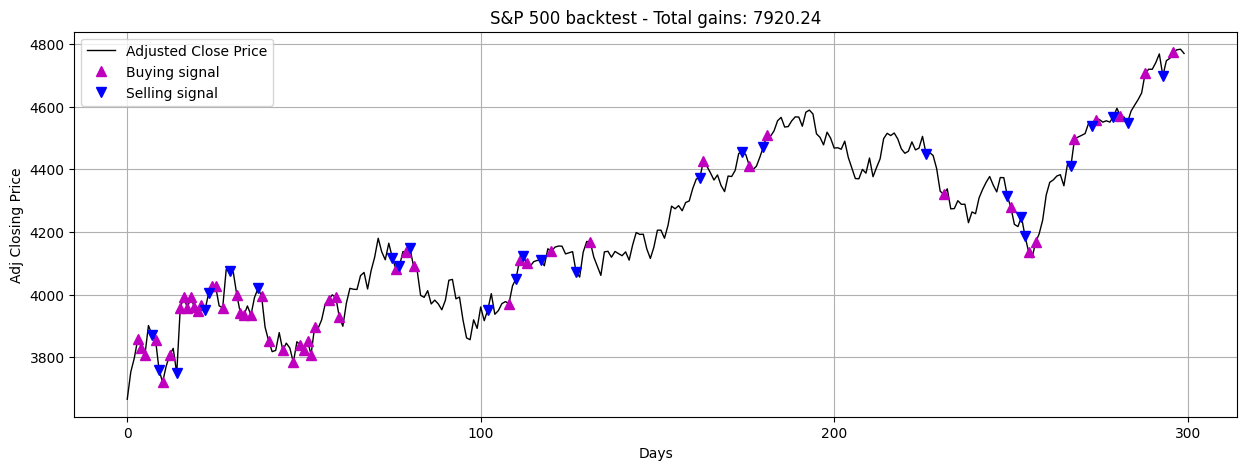

Cumulative Return: 0.2175
Annualized Return: 0.1798
Annualized Std: 0.1190
Sharpe Ratio: 1.4535
Sortino Ratio: 2.3209
Max Drawdown: -0.0979
Max Drawdown Length: 63 days


In [25]:
# S&P 500 with sentiment
window_size = 10
ticker = "S&P 500"

test_env = TradingEnvironment(X_test, adj_close_prices_test, window_size, initial_cash=100000)

# Clear the session to prevent carryover
K.clear_session()

# Instantiate the A3C agent for testing
a3c_agent_test = A3CAgent(window_size, len(X_test.columns), is_eval=True)

# Load the saved model to ensure proper weight initialization
a3c_agent_test.actor_model = load_model(f"actor_model.keras")
a3c_agent_test.critic_model = load_model(f"critic_model.keras")

# Reset the agent before testing to ensure no carryover of state from training
a3c_agent_test.reset()

# Perform testing
test_sharpe_ratio = test_a3c_agent(a3c_agent_test, test_env)
calculate_performance_metrics(test_env.portfolio_values)
pd.DataFrame(test_env.portfolio_values).to_csv('S&P 500 A3C sentiment.csv', index=False)

Exploitation: Action probabilities in act function: [[0.3935 0.3406 0.2659]]
Action: 0, Cash: 100000, Inventory: 0
End of day inventory: 0
Day 0, Action: 0, inventory(t-1): 0
Action probabilities at step 0: [0.3935 0.3406 0.2659]

Exploitation: Action probabilities in act function: [[0.4847 0.372  0.1433]]
Action: 0, Cash: 100000, Inventory: 0
End of day inventory: 0
Day 1, Action: 0, inventory(t-1): 0
Action probabilities at step 1: [0.4847 0.372  0.1433]

Exploitation: Action probabilities in act function: [[0.3923 0.3531 0.2546]]
Action: 0, Cash: 100000, Inventory: 0
End of day inventory: 0
Day 2, Action: 0, inventory(t-1): 0
Action probabilities at step 2: [0.3923 0.3531 0.2546]

Exploitation: Action probabilities in act function: [[0.444  0.3288 0.2272]]
Action: 0, Cash: 100000, Inventory: 0
End of day inventory: 0
Day 3, Action: 0, inventory(t-1): 0
Action probabilities at step 3: [0.444  0.3288 0.2272]

Exploitation: Action probabilities in act function: [[0.3333 0.3945 0.2722]]

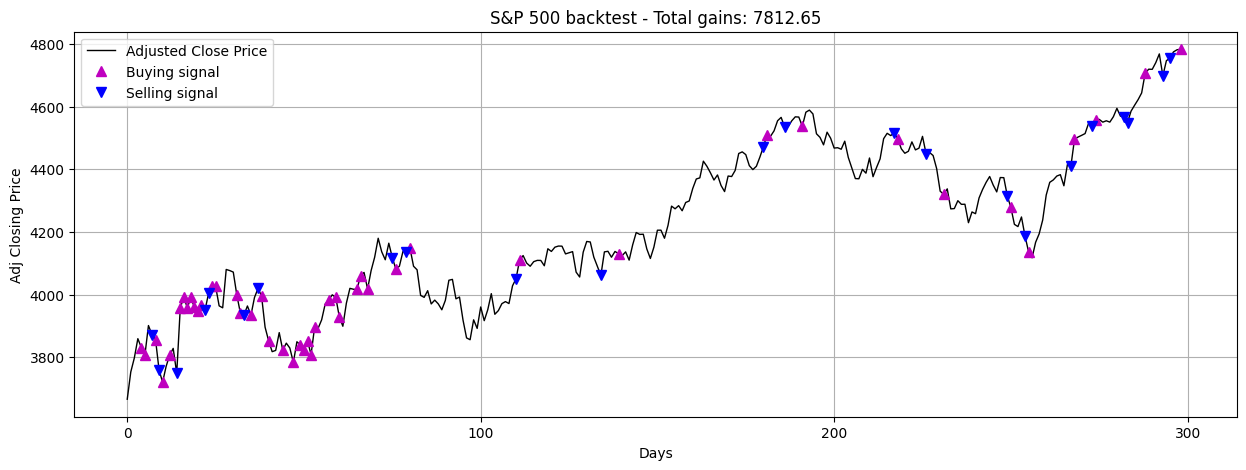

Cumulative Return: 0.2098
Annualized Return: 0.1735
Annualized Std: 0.1171
Sharpe Ratio: 1.4306
Sortino Ratio: 2.2487
Max Drawdown: -0.0992
Max Drawdown Length: 63 days


In [ ]:
# S&P 500 without sentiment
window_size = 10
ticker = "S&P 500"

# Testing environment instantiation
test_env = TradingEnvironment(X_test, adj_close_prices_test, window_size, initial_cash=100000)

# Clear the session to prevent carryover
K.clear_session()

# Instantiate the A3C agent for testing
a3c_agent_test = A3CAgent(window_size, len(X_test.columns), is_eval=True)

# Load the saved model to ensure proper weight initialization
a3c_agent_test.actor_model = load_model(f"actor_model.keras")
a3c_agent_test.critic_model = load_model(f"critic_model.keras")

# Reset the agent before testing to ensure no carryover of state from training
a3c_agent_test.reset()

# Perform testing
test_sharpe_ratio = test_a3c_agent(a3c_agent_test, test_env)
calculate_performance_metrics(test_env.portfolio_values)
pd.DataFrame(test_env.portfolio_values).to_csv('S&P 500 A3C no sentiment.csv', index=False)

# Trading Env

In [17]:
class TradingEnv(gym.Env):
    """Custom Environment that follows OpenAI Gym interface."""
    metadata = {'render.modes': ['human']}

    def __init__(self, data, adj_close_prices, initial_cash=10000, window_size=10):
        super(TradingEnv, self).__init__()

        # Define the action space: 0 -> Hold, 1 -> Buy, 2 -> Sell
        self.action_space = spaces.Discrete(3)

        # State space: historical window of prices and portfolio state
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(window_size, data.shape[1]), dtype=np.float32)

        # Financial Data
        self.data = data
        self.window_size = window_size
        self.initial_cash = initial_cash
        self.adj_close_prices = adj_close_prices
        self.states_sell = []
        self.states_buy = []
        self.reset()

    def reset(self):
        """Reset the environment to start a new episode."""
        self.current_step = self.window_size
        self.cash = self.initial_cash
        self.inventory = []
        self.total_profit = 0
        self.done = False
        self.portfolio_value = [self.cash]
        self.states_sell = []
        self.states_buy = []

        return self._next_observation()

    def _next_observation(self):
        return self.data.iloc[self.current_step - self.window_size:self.current_step].values

    def _get_portfolio_value(self, current_price):
        stock_value = sum(self.inventory) if len(self.inventory) > 0 else 0
        return self.cash + len(self.inventory) * current_price

    def step(self, action):
        # Get the current price and determine the reward
        current_price = self.adj_close_prices.iloc[self.current_step - self.window_size]['Adj Close']

        reward = 0

        # Execute the action
        if action == 1:  # Buy
            if self.cash >= current_price:
                self.inventory.append(current_price)
                self.cash -= current_price
                self.states_buy.append(self.current_step)
                reward = 0
            else:
                reward = -0.001  # Penalty for not being able to buy due to insufficient cash

        elif action == 2:  # Sell
            if len(self.inventory) > 0:
                bought_price = self.inventory.pop(0)
                profit = current_price - bought_price
                reward = profit/bought_price
                self.cash += current_price
                self.total_profit += profit
                self.states_sell.append(self.current_step)
            else:
                reward = -0.001  # Penalty for trying to sell without inventory

        else:  # Hold
            reward = -0.001

        # Update the portfolio value
        self.portfolio_value.append(self._get_portfolio_value(current_price))

        # Move to the next step
        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            self.done = True

        # Get the next state (next window of data)
        next_state = self._next_observation()

        return next_state, reward, self.done, {}

    def render(self, mode='human'):
        """Render the environment (plot the portfolio value over time)."""
        print(f'Step: {self.current_step}, Cash: {self.cash}, Inventory: {len(self.inventory)}, Total Profit: {self.total_profit}, portfolio value: {self.portfolio_value[-1]}')
        calculate_performance_metrics(self.portfolio_value)
        pd.DataFrame(self.portfolio_value).to_csv('portfolio_value.csv', index=False)

    def close(self):
        pass


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# PPO

In [ ]:
# NASDAQ
train_env = TradingEnv(X_train, adj_close_prices_train, initial_cash=100000, window_size=10)
# Initialize and train the PPO agent
ppo_agent = PPO('MlpPolicy', train_env, verbose=1)
ppo_agent.learn(total_timesteps=10000)
ppo_agent.save("ppo_trading_agent")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 789      |
|    ep_rew_mean     | 1.83     |
| time/              |          |
|    fps             | 504      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 789         |
|    ep_rew_mean          | 2.08        |
| time/                   |             |
|    fps                  | 393         |
|    iterations           | 2           |
|    time_elapsed         | 10          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007883556 |
|    clip_fraction        | 0.0496      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.324      |
|    learning_rate        | 0.

Step: 11, Cash: 89385.16016, Inventory: 1, Total Profit: 0, portfolio value: 100000.0
Cumulative Return: 0.0000
Annualized Return: 0.0000
Annualized Std: 0.0000
Sharpe Ratio: 0.0000
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 12, Cash: 78525.44043, Inventory: 2, Total Profit: 0, portfolio value: 100244.87989000001
Cumulative Return: 0.0024
Annualized Return: 0.2281
Annualized Std: 0.0194
Sharpe Ratio: 15.8745
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 13, Cash: 89478.05078, Inventory: 1, Total Profit: 337.7705100000003, portfolio value: 100430.66113000001
Cumulative Return: 0.0043
Annualized Return: 0.3109
Annualized Std: 0.0166
Sharpe Ratio: 21.8312
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 14, Cash: 78278.93066000001, Inventory: 2, Total Profit: 337.7705100000003, portfolio value: 100677.17090000001
Cumulative Return: 0.0068
Annualized Return: 0.4051
Annualized Std: 0.0160
Sharpe Ratio: 26.67

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret

Step: 31, Cash: 35843.481440000025, Inventory: 6, Total Profit: 821.0009799999989, portfolio value: 102713.24120000002
Cumulative Return: 0.0271
Annualized Return: 0.3589
Annualized Std: 0.1909
Sharpe Ratio: 1.7771
Sortino Ratio: 5.7810
Max Drawdown: -0.0290
Max Drawdown Length: 11 days
Step: 32, Cash: 24697.421870000027, Inventory: 7, Total Profit: 821.0009799999989, portfolio value: 102719.83886000002
Cumulative Return: 0.0272
Annualized Return: 0.3418
Annualized Std: 0.1866
Sharpe Ratio: 1.7398
Sortino Ratio: 5.5307
Max Drawdown: -0.0290
Max Drawdown Length: 11 days
Step: 33, Cash: 24697.421870000027, Inventory: 7, Total Profit: 821.0009799999989, portfolio value: 101868.99026000002
Cumulative Return: 0.0187
Annualized Return: 0.2146
Annualized Std: 0.1851
Sharpe Ratio: 1.1872
Sortino Ratio: 3.8791
Max Drawdown: -0.0290
Max Drawdown Length: 11 days
Step: 34, Cash: 13523.011710000028, Inventory: 8, Total Profit: 821.0009799999989, portfolio value: 102918.29299000002
Cumulative Return

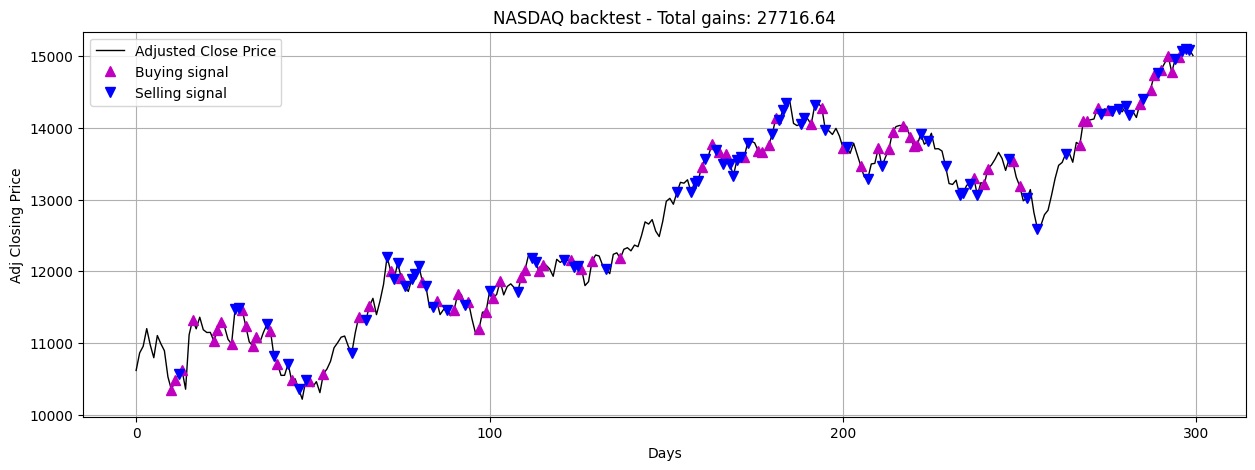

In [ ]:
# Test the trained agent
ticker = "NASDAQ"
window_size = 10
obs = test_env.reset()
test_env = TradingEnv(X_test, adj_close_prices_test, initial_cash=100000, window_size=window_size)
for _ in range(len(X_test) - 10):  # Play through the entire dataset
    action, _states = ppo_agent.predict(obs)
    obs, rewards, done, info = test_env.step(action)
    test_env.render()
    if done:
        plot_trading(ticker,
                          data_input=adj_close_prices_test,
                          states_buy=test_env.states_buy,
                          states_sell=test_env.states_sell,
                          profit=test_env.total_profit,
                          episode_number='test',
                          training = False)
        break

In [ ]:
# DJIA
# Initialize the trading environment
train_env = TradingEnv(X_train, adj_close_prices_train, initial_cash=100000, window_size=10)
# Initialize and train the PPO agent
ppo_agent = PPO('MlpPolicy', train_env, verbose=1)
ppo_agent.learn(total_timesteps=10000)
ppo_agent.save("ppo_trading_agent")


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 789      |
|    ep_rew_mean     | 0.584    |
| time/              |          |
|    fps             | 491      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 789         |
|    ep_rew_mean          | 0.178       |
| time/                   |             |
|    fps                  | 408         |
|    iterations           | 2           |
|    time_elapsed         | 10          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008792799 |
|    clip_fraction        | 0.0899      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -2.42       |
|    learning_rate        | 0.

Step: 11, Cash: 100000, Inventory: 0, Total Profit: 0, portfolio value: 100000.0
Cumulative Return: 0.0000
Annualized Return: 0.0000
Annualized Std: 0.0000
Sharpe Ratio: 0.0000
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 12, Cash: 68917.43945, Inventory: 1, Total Profit: 0, portfolio value: 100000.0
Cumulative Return: 0.0000
Annualized Return: 0.0000
Annualized Std: 0.0000
Sharpe Ratio: 0.0000
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 13, Cash: 37417.82031000001, Inventory: 2, Total Profit: 0, portfolio value: 100417.05859
Cumulative Return: 0.0042
Annualized Return: 0.2998
Annualized Std: 0.0312
Sharpe Ratio: 11.2250
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 14, Cash: 5581.080080000011, Inventory: 3, Total Profit: 0, portfolio value: 101091.30077000002
Cumulative Return: 0.0109
Annualized Return: 0.7281
Annualized Std: 0.0455
Sharpe Ratio: 15.0726
Sortino Ratio: nan
Max Drawdown: 0.0000
Max D

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret


Annualized Return: 0.5930
Annualized Std: 0.1505
Sharpe Ratio: 3.2821
Sortino Ratio: 5.0825
Max Drawdown: -0.0218
Max Drawdown Length: 4 days
Step: 39, Cash: 106241.33594000002, Inventory: 0, Total Profit: 6241.335940000008, portfolio value: 106241.33594000002
Cumulative Return: 0.0624
Annualized Return: 0.6629
Annualized Std: 0.1486
Sharpe Ratio: 3.6182
Sortino Ratio: 5.5320
Max Drawdown: -0.0218
Max Drawdown Length: 4 days
Step: 40, Cash: 106241.33594000002, Inventory: 0, Total Profit: 6241.335940000008, portfolio value: 106241.33594000002
Cumulative Return: 0.0624
Annualized Return: 0.6358
Annualized Std: 0.1462
Sharpe Ratio: 3.5543
Sortino Ratio: 5.3476
Max Drawdown: -0.0218
Max Drawdown Length: 4 days
Step: 41, Cash: 106241.33594000002, Inventory: 0, Total Profit: 6241.335940000008, portfolio value: 106241.33594000002
Cumulative Return: 0.0624
Annualized Return: 0.6109
Annualized Std: 0.1439
Sharpe Ratio: 3.4937
Sortino Ratio: 5.1751
Max Drawdown: -0.0218
Max Drawdown Length: 4 d

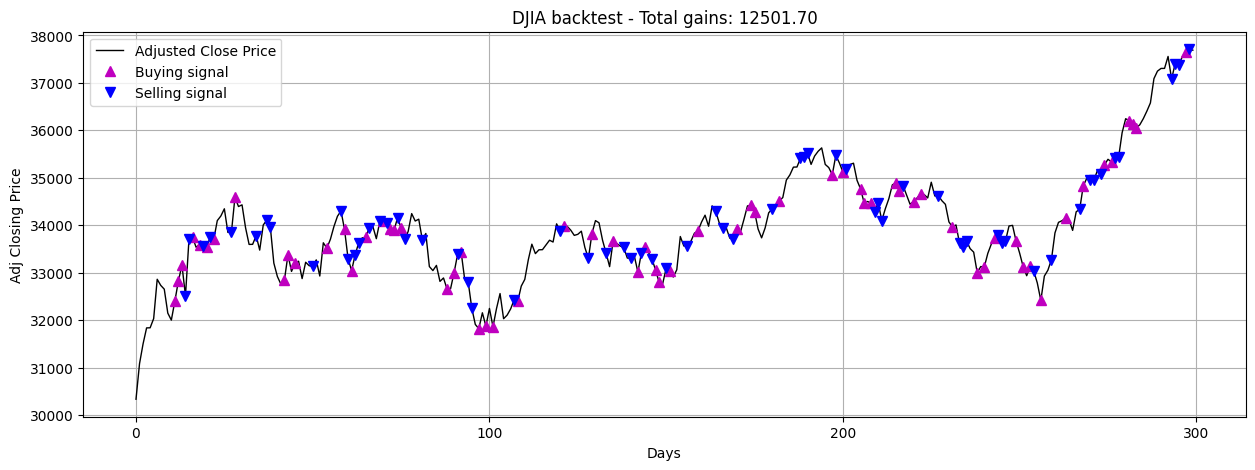

In [ ]:
# Test the trained agent
ticker = "DJIA"
window_size = 10

test_env = TradingEnv(X_test, adj_close_prices_test, initial_cash=100000, window_size=window_size)
obs = test_env.reset()
for _ in range(len(X_test) - 10):  # Play through the entire dataset
    action, _states = ppo_agent.predict(obs)
    obs, rewards, done, info = test_env.step(action)
    test_env.render()
    if done:
        plot_trading(ticker,
                          data_input=adj_close_prices_test,
                          states_buy=test_env.states_buy,
                          states_sell=test_env.states_sell,
                          profit=test_env.total_profit,
                          episode_number='test',
                          training = False)
        break

# A2C

In [ ]:
# NASDAQ
# Initialize and train the A2C agent
a2c_agent = A2C('MlpPolicy', train_env, verbose=1)
a2c_agent.learn(total_timesteps=10000)
a2c_agent.save("a2c_trading_agent")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| time/                 |          |
|    fps                | 188      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.02    |
|    explained_variance | -19.8    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.0594   |
|    value_loss         | 0.00629  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 789      |
|    ep_rew_mean        | -0.886   |
| time/                 |          |
|    fps                | 214      |
|    iterations         | 200      |
|    time_elapsed       | 4        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss

Step: 11, Cash: 89385.16016, Inventory: 1, Total Profit: 0, portfolio value: 100000.0
Cumulative Return: 0.0000
Annualized Return: 0.0000
Annualized Std: 0.0000
Sharpe Ratio: 0.0000
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 12, Cash: 100244.87989, Inventory: 0, Total Profit: 244.87989000000016, portfolio value: 100244.87989
Cumulative Return: 0.0024
Annualized Return: 0.2281
Annualized Std: 0.0194
Sharpe Ratio: 15.8745
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 13, Cash: 100244.87989, Inventory: 0, Total Profit: 244.87989000000016, portfolio value: 100244.87989
Cumulative Return: 0.0024
Annualized Return: 0.1666
Annualized Std: 0.0183
Sharpe Ratio: 11.2250
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 14, Cash: 100244.87989, Inventory: 0, Total Profit: 244.87989000000016, portfolio value: 100244.87989
Cumulative Return: 0.0024
Annualized Return: 0.1312
Annualized Std: 0.0168
Sharpe Ratio: 9.1652


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret

Cumulative Return: 0.0024
Annualized Return: 0.0393
Annualized Std: 0.0097
Sharpe Ratio: 4.2426
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 26, Cash: 100244.87989, Inventory: 0, Total Profit: 244.87989000000016, portfolio value: 100244.87989
Cumulative Return: 0.0024
Annualized Return: 0.0369
Annualized Std: 0.0094
Sharpe Ratio: 4.0988
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 27, Cash: 100244.87989, Inventory: 0, Total Profit: 244.87989000000016, portfolio value: 100244.87989
Cumulative Return: 0.0024
Annualized Return: 0.0348
Annualized Std: 0.0091
Sharpe Ratio: 3.9686
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 28, Cash: 100244.87989, Inventory: 0, Total Profit: 244.87989000000016, portfolio value: 100244.87989
Cumulative Return: 0.0024
Annualized Return: 0.0330
Annualized Std: 0.0089
Sharpe Ratio: 3.8501
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 29, Cash: 1002

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret


Cumulative Return: 0.0024
Annualized Return: 0.0215
Annualized Std: 0.0072
Sharpe Ratio: 3.0551
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 39, Cash: 100244.87989, Inventory: 0, Total Profit: 244.87989000000016, portfolio value: 100244.87989
Cumulative Return: 0.0024
Annualized Return: 0.0208
Annualized Std: 0.0071
Sharpe Ratio: 3.0000
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 40, Cash: 100244.87989, Inventory: 0, Total Profit: 244.87989000000016, portfolio value: 100244.87989
Cumulative Return: 0.0024
Annualized Return: 0.0201
Annualized Std: 0.0070
Sharpe Ratio: 2.9478
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 41, Cash: 100244.87989, Inventory: 0, Total Profit: 244.87989000000016, portfolio value: 100244.87989
Cumulative Return: 0.0024
Annualized Return: 0.0194
Annualized Std: 0.0069
Sharpe Ratio: 2.8983
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 42, Cash: 100

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret

Step: 58, Cash: 100244.87989, Inventory: 0, Total Profit: 244.87989000000016, portfolio value: 100244.87989
Cumulative Return: 0.0024
Annualized Return: 0.0127
Annualized Std: 0.0056
Sharpe Ratio: 2.3155
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 59, Cash: 100244.87989, Inventory: 0, Total Profit: 244.87989000000016, portfolio value: 100244.87989
Cumulative Return: 0.0024
Annualized Return: 0.0124
Annualized Std: 0.0055
Sharpe Ratio: 2.2913
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 60, Cash: 100244.87989, Inventory: 0, Total Profit: 244.87989000000016, portfolio value: 100244.87989
Cumulative Return: 0.0024
Annualized Return: 0.0122
Annualized Std: 0.0054
Sharpe Ratio: 2.2678
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 61, Cash: 100244.87989, Inventory: 0, Total Profit: 244.87989000000016, portfolio value: 100244.87989
Cumulative Return: 0.0024
Annualized Return: 0.0119
Annualized Std: 0.0054
S

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret

Annualized Std: 0.0063
Sharpe Ratio: 0.0082
Sortino Ratio: 0.0087
Max Drawdown: -0.0031
Max Drawdown Length: 16 days
Step: 86, Cash: 100000.93947000001, Inventory: 0, Total Profit: 0.9394699999993463, portfolio value: 100000.93947000001
Cumulative Return: 0.0000
Annualized Return: 0.0000
Annualized Std: 0.0062
Sharpe Ratio: 0.0081
Sortino Ratio: 0.0086
Max Drawdown: -0.0031
Max Drawdown Length: 16 days
Step: 87, Cash: 100000.93947000001, Inventory: 0, Total Profit: 0.9394699999993463, portfolio value: 100000.93947000001
Cumulative Return: 0.0000
Annualized Return: 0.0000
Annualized Std: 0.0062
Sharpe Ratio: 0.0081
Sortino Ratio: 0.0085
Max Drawdown: -0.0031
Max Drawdown Length: 16 days
Step: 88, Cash: 100000.93947000001, Inventory: 0, Total Profit: 0.9394699999993463, portfolio value: 100000.93947000001
Cumulative Return: 0.0000
Annualized Return: 0.0000
Annualized Std: 0.0061
Sharpe Ratio: 0.0080
Sortino Ratio: 0.0084
Max Drawdown: -0.0031
Max Drawdown Length: 16 days
Step: 89, Cash: 

<ipython-input-11-c33cb9aefdd3>:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_input.index = pd.to_datetime(data_input.index)


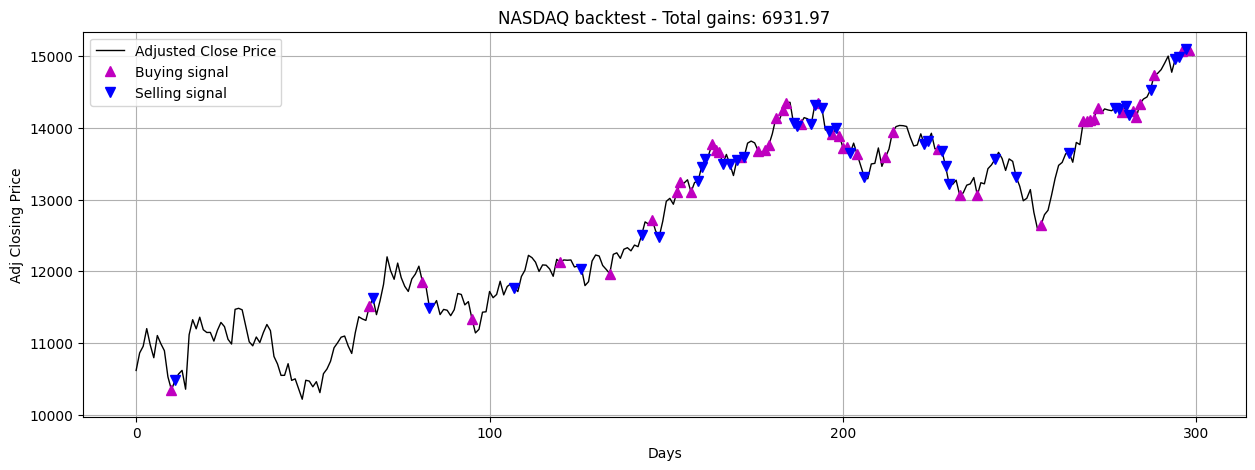

In [ ]:
# Test the trained agent
ticker = "NASDAQ"
window_size = 10
obs = test_env.reset()
test_env = TradingEnv(X_test, adj_close_prices_test, initial_cash=100000, window_size=window_size)
for _ in range(len(X_test) - 10):  # Play through the entire dataset
    action, _states = a2c_agent.predict(obs)
    obs, rewards, done, info = test_env.step(action)
    test_env.render()
    if done:
        plot_trading(ticker,
                          data_input=adj_close_prices_test,
                          states_buy=test_env.states_buy,
                          states_sell=test_env.states_sell,
                          profit=test_env.total_profit,
                          episode_number='test',
                          training = False)
        break

In [ ]:
# DJIA
# Initialize and train the A2C agent
a2c_agent = A2C('MlpPolicy', train_env, verbose=1)
a2c_agent.learn(total_timesteps=10000)
a2c_agent.save("a2c_trading_agent")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.06    |
|    explained_variance | -24.4    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.142    |
|    value_loss         | 0.0221   |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 789      |
|    ep_rew_mean        | 0.527    |
| time/                 |          |
|    fps                | 235      |
|    iterations         | 200      |
|    time_elapsed       | 4        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.927   |
|    explained_variance | -961     |
|    learning_rate      | 0.0007   |
|

Step: 11, Cash: 69666.41016, Inventory: 1, Total Profit: 0, portfolio value: 100000.0
Cumulative Return: 0.0000
Annualized Return: 0.0000
Annualized Std: 0.0000
Sharpe Ratio: 0.0000
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 12, Cash: 38583.849610000005, Inventory: 2, Total Profit: 0, portfolio value: 100748.97071
Cumulative Return: 0.0075
Annualized Return: 0.8716
Annualized Std: 0.0594
Sharpe Ratio: 15.8745
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 13, Cash: 70083.46875, Inventory: 1, Total Profit: 1166.0292999999983, portfolio value: 101583.08789
Cumulative Return: 0.0158
Annualized Return: 1.6900
Annualized Std: 0.0592
Sharpe Ratio: 22.3660
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 14, Cash: 101920.20898, Inventory: 0, Total Profit: 1920.2089799999994, portfolio value: 101920.20898
Cumulative Return: 0.0192
Annualized Return: 1.6081
Annualized Std: 0.0530
Sharpe Ratio: 22.6933
Sortino Rat

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret


Annualized Return: 0.2269
Annualized Std: 0.0363
Sharpe Ratio: 5.8697
Sortino Ratio: inf
Max Drawdown: -0.0013
Max Drawdown Length: 4 days
Step: 37, Cash: 102215.13672, Inventory: 0, Total Profit: 2215.1367199999986, portfolio value: 102215.13672
Cumulative Return: 0.0222
Annualized Return: 0.2180
Annualized Std: 0.0357
Sharpe Ratio: 5.7454
Sortino Ratio: inf
Max Drawdown: -0.0013
Max Drawdown Length: 4 days
Step: 38, Cash: 102215.13672, Inventory: 0, Total Profit: 2215.1367199999986, portfolio value: 102215.13672
Cumulative Return: 0.0222
Annualized Return: 0.2097
Annualized Std: 0.0352
Sharpe Ratio: 5.6287
Sortino Ratio: inf
Max Drawdown: -0.0013
Max Drawdown Length: 4 days
Step: 39, Cash: 67625.36718999999, Inventory: 1, Total Profit: 2215.1367199999986, portfolio value: 102215.13671999998
Cumulative Return: 0.0222
Annualized Return: 0.2021
Annualized Std: 0.0346
Sharpe Ratio: 5.5189
Sortino Ratio: 19.0397
Max Drawdown: -0.0013
Max Drawdown Length: 4 days
Step: 40, Cash: 102020.378

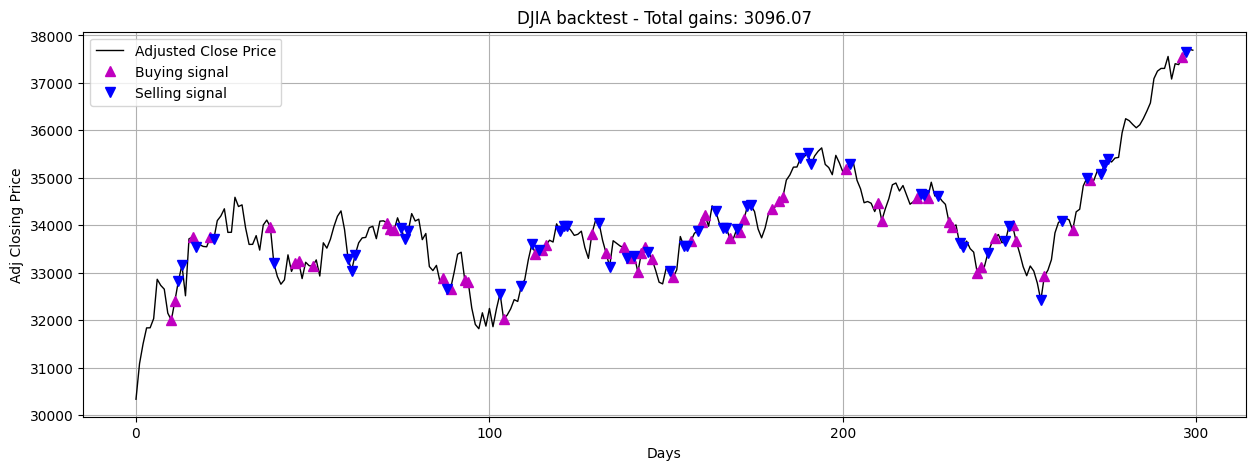

In [ ]:
# Test the trained agent
ticker = "DJIA"
window_size = 10
obs = test_env.reset()
test_env = TradingEnv(X_test, adj_close_prices_test, initial_cash=100000, window_size=window_size)
for _ in range(len(X_test) - 10):  # Play through the entire dataset
    action, _states = a2c_agent.predict(obs)
    obs, rewards, done, info = test_env.step(action)
    test_env.render()
    if done:
        plot_trading(ticker,
                          data_input=adj_close_prices_test,
                          states_buy=test_env.states_buy,
                          states_sell=test_env.states_sell,
                          profit=test_env.total_profit,
                          episode_number='test',
                          training = False)
        break

# DQN

In [86]:
# NASDAQ
# Initialize and train the DQN agent
dqn_agent = DQN('MlpPolicy', train_env, verbose=1)
dqn_agent.learn(total_timesteps=10000)
dqn_agent.save("dqn_trading_agent")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.2e+03  |
|    ep_rew_mean      | 3.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 439      |
|    time_elapsed     | 10       |
|    total_timesteps  | 4784     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00018  |
|    n_updates        | 1170     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.2e+03  |
|    ep_rew_mean      | 3.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 389      |
|    time_elapsed     | 24       |
|    total_timesteps  | 9568     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000314 |
|    n_updates      

Step: 11, Cash: 100000, Inventory: 0, Total Profit: 0, portfolio value: 100000.0
Cumulative Return: 0.0000
Annualized Return: 0.0000
Annualized Std: 0.0000
Sharpe Ratio: 0.0000
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 12, Cash: 100000, Inventory: 0, Total Profit: 0, portfolio value: 100000.0
Cumulative Return: 0.0000
Annualized Return: 0.0000
Annualized Std: 0.0000
Sharpe Ratio: 0.0000
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 13, Cash: 100000, Inventory: 0, Total Profit: 0, portfolio value: 100000.0
Cumulative Return: 0.0000
Annualized Return: 0.0000
Annualized Std: 0.0000
Sharpe Ratio: 0.0000
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 14, Cash: 100000, Inventory: 0, Total Profit: 0, portfolio value: 100000.0
Cumulative Return: 0.0000
Annualized Return: 0.0000
Annualized Std: 0.0000
Sharpe Ratio: 0.0000
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 15, Cash: 1000

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret


Step: 39, Cash: 89837.45021, Inventory: 1, Total Profit: 821.2304799999984, portfolio value: 101305.45021
Cumulative Return: 0.0131
Annualized Return: 0.1151
Annualized Std: 0.0320
Sharpe Ratio: 3.5413
Sortino Ratio: 4.8466
Max Drawdown: -0.0040
Max Drawdown Length: 6 days
Step: 40, Cash: 101319.90041, Inventory: 0, Total Profit: 1319.9004099999984, portfolio value: 101319.90041
Cumulative Return: 0.0132
Annualized Return: 0.1125
Annualized Std: 0.0315
Sharpe Ratio: 3.5185
Sortino Ratio: 4.7364
Max Drawdown: -0.0040
Max Drawdown Length: 6 days
Step: 41, Cash: 101319.90041, Inventory: 0, Total Profit: 1319.9004099999984, portfolio value: 101319.90041
Cumulative Return: 0.0132
Annualized Return: 0.1088
Annualized Std: 0.0310
Sharpe Ratio: 3.4585
Sortino Ratio: 4.5836
Max Drawdown: -0.0040
Max Drawdown Length: 6 days
Step: 42, Cash: 101319.90041, Inventory: 0, Total Profit: 1319.9004099999984, portfolio value: 101319.90041
Cumulative Return: 0.0132
Annualized Return: 0.1053
Annualized St

<ipython-input-11-c33cb9aefdd3>:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_input.index = pd.to_datetime(data_input.index)


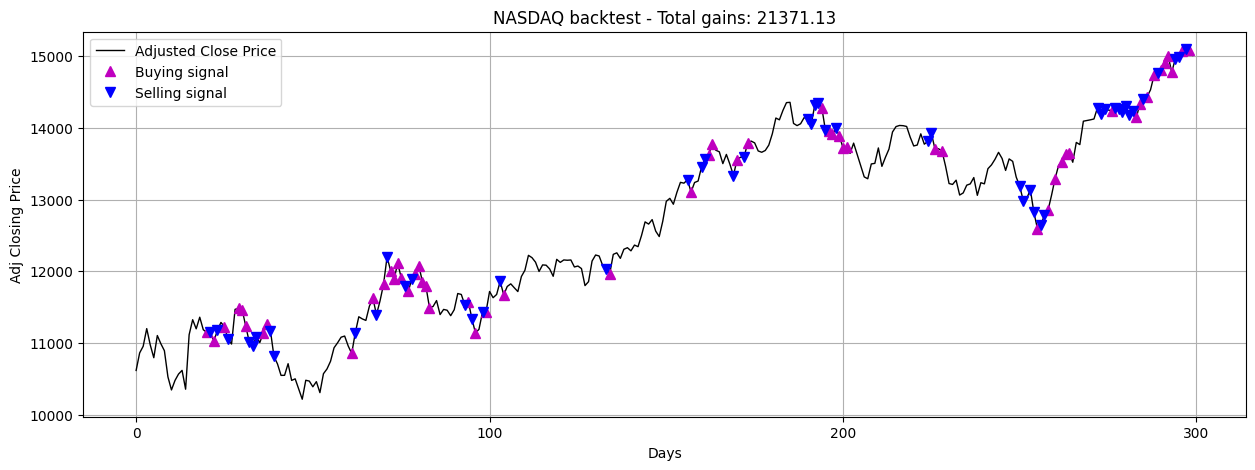

In [ ]:
ticker = "NASDAQ"
window_size = 10
obs = test_env.reset()
test_env = TradingEnv(X_test, adj_close_prices_test, initial_cash=100000, window_size=window_size)
for _ in range(len(X_test) - 10):
    action, _states = dqn_agent.predict(obs)
    obs, rewards, done, info = test_env.step(action)
    test_env.render()
    if done:
        plot_trading(ticker,
                          data_input=adj_close_prices_test,
                          states_buy=test_env.states_buy,
                          states_sell=test_env.states_sell,
                          profit=test_env.total_profit,
                          episode_number='test',
                          training = False)
        break

In [ ]:
# DJIA
# Initialize and train the DQN agent
dqn_agent = DQN('MlpPolicy', train_env, verbose=1)
dqn_agent.learn(total_timesteps=10000)
dqn_agent.save("dqn_trading_agent")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 789      |
|    ep_rew_mean      | -0.286   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 688      |
|    time_elapsed     | 4        |
|    total_timesteps  | 3156     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000217 |
|    n_updates        | 763      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 789      |
|    ep_rew_mean      | -0.398   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 721      |
|    time_elapsed     | 8        |
|    total_timesteps  | 6312     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000224 |
|    n_updates      

Step: 11, Cash: 100000, Inventory: 0, Total Profit: 0, portfolio value: 100000.0
Cumulative Return: 0.0000
Annualized Return: 0.0000
Annualized Std: 0.0000
Sharpe Ratio: 0.0000
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 12, Cash: 100000, Inventory: 0, Total Profit: 0, portfolio value: 100000.0
Cumulative Return: 0.0000
Annualized Return: 0.0000
Annualized Std: 0.0000
Sharpe Ratio: 0.0000
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 13, Cash: 100000, Inventory: 0, Total Profit: 0, portfolio value: 100000.0
Cumulative Return: 0.0000
Annualized Return: 0.0000
Annualized Std: 0.0000
Sharpe Ratio: 0.0000
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 14, Cash: 100000, Inventory: 0, Total Profit: 0, portfolio value: 100000.0
Cumulative Return: 0.0000
Annualized Return: 0.0000
Annualized Std: 0.0000
Sharpe Ratio: 0.0000
Sortino Ratio: nan
Max Drawdown: 0.0000
Max Drawdown Length: 0 days
Step: 15, Cash: 1000

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret

Step: 45, Cash: 34005.99802999999, Inventory: 2, Total Profit: 2033.7988200000036, portfolio value: 101568.95896999999
Cumulative Return: 0.0157
Annualized Return: 0.1151
Annualized Std: 0.0586
Sharpe Ratio: 1.9424
Sortino Ratio: 2.3064
Max Drawdown: -0.0162
Max Drawdown Length: 2 days
Step: 46, Cash: 529.5370899999907, Inventory: 3, Total Profit: 2033.7988200000036, portfolio value: 100958.91991
Cumulative Return: 0.0096
Annualized Return: 0.0672
Annualized Std: 0.0602
Sharpe Ratio: 1.1401
Sortino Ratio: 1.5060
Max Drawdown: -0.0168
Max Drawdown Length: 5 days
Step: 47, Cash: 34534.57614999999, Inventory: 2, Total Profit: 1608.958970000007, portfolio value: 102544.65427
Cumulative Return: 0.0254
Annualized Return: 0.1813
Annualized Std: 0.0714
Sharpe Ratio: 2.4321
Sortino Ratio: 3.8131
Max Drawdown: -0.0168
Max Drawdown Length: 5 days
Step: 48, Cash: 34534.57614999999, Inventory: 2, Total Profit: 1608.958970000007, portfolio value: 102751.85741
Cumulative Return: 0.0275
Annualized Ret

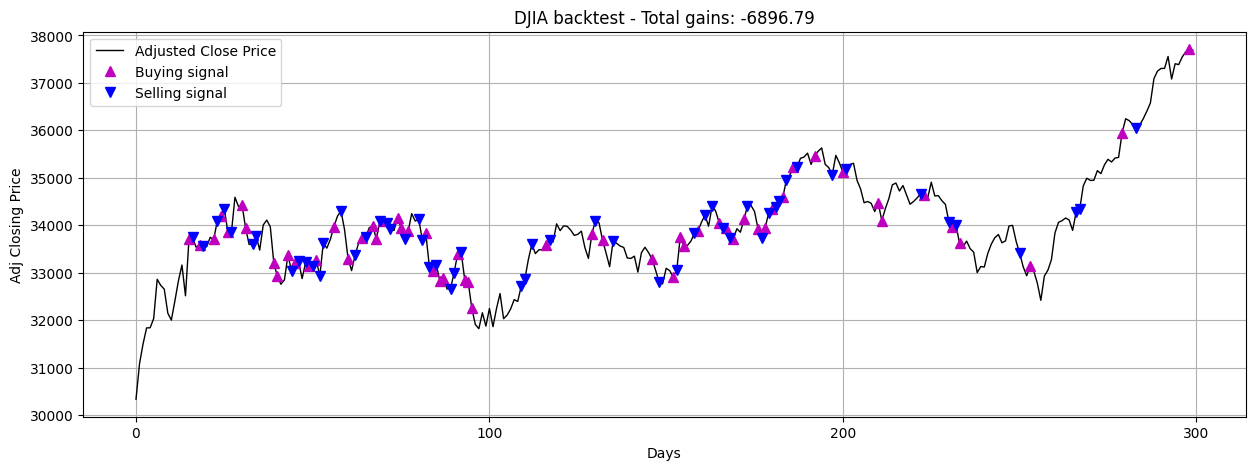

In [ ]:
ticker = "DJIA"
window_size = 10
obs = test_env.reset()
test_env = TradingEnv(X_test, adj_close_prices_test, initial_cash=100000, window_size=window_size)
for _ in range(len(X_test) - 10):
    action, _states = dqn_agent.predict(obs)
    obs, rewards, done, info = test_env.step(action)
    test_env.render()
    if done:
        plot_trading(ticker,
                          data_input=adj_close_prices_test,
                          states_buy=test_env.states_buy,
                          states_sell=test_env.states_sell,
                          profit=test_env.total_profit,
                          episode_number='test',
                          training = False)
        break

# CR Plot

In [ ]:
file_path = 'S&P_CR.csv'
sp500_data = pd.read_csv(file_path)

In [ ]:
def plot_cumulative_returns(data):
    # Cleaning the data column names (removing spaces and commas)_
    data.columns = ['A2C-Vanilla', 'PPO-Vanilla', 'DQN-Vanilla', 'A3C_CNN-BiLSTM', 'Sentiment-Aware A3C_CNN-BiLSTM']

    # Plotting the data
    plt.figure(figsize=(15, 7))

    # Plot each series in the dataset
    for column in data.columns:
        plt.plot(data[column]*100, label=column)

    # Add legend, labels, and title
    plt.legend()
    #plt.title('S&P 500 Comparison of Trading Strategies')
    plt.xlabel('Days')
    plt.ylabel('Cumulative Return(%)')
    plt.grid(True)
    # Show the plot
    plt.show()

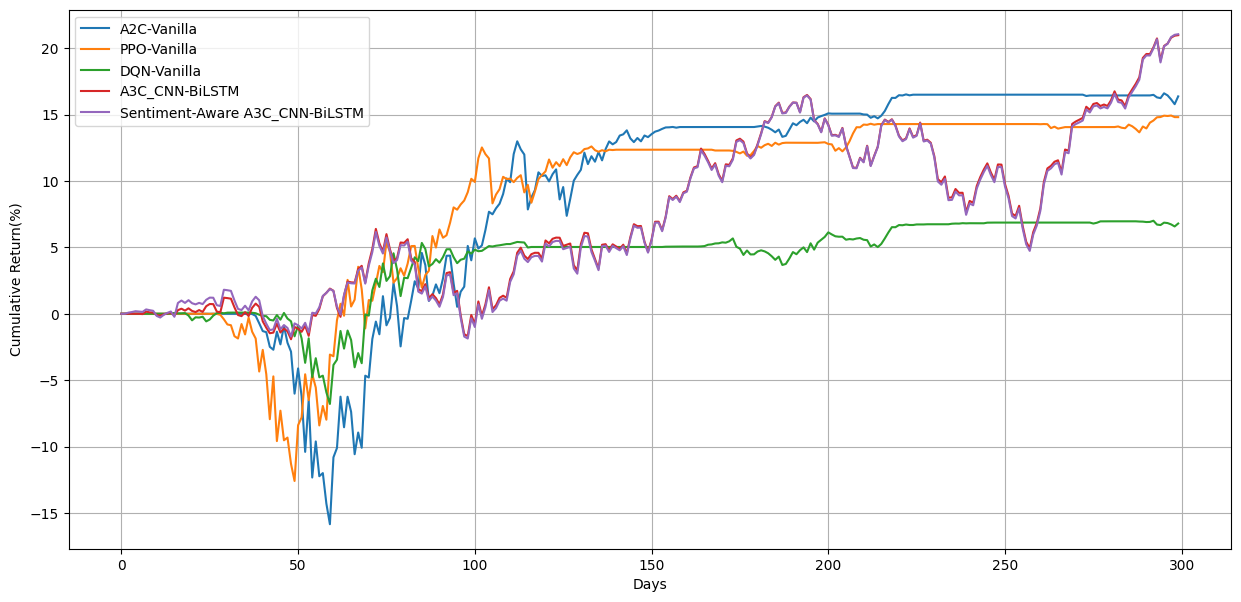

In [ ]:
plot_cumulative_returns(sp500_data)

In [ ]:
file_path = 'NASDAQ_CR.csv'
NASDAQ_data = pd.read_csv(file_path)

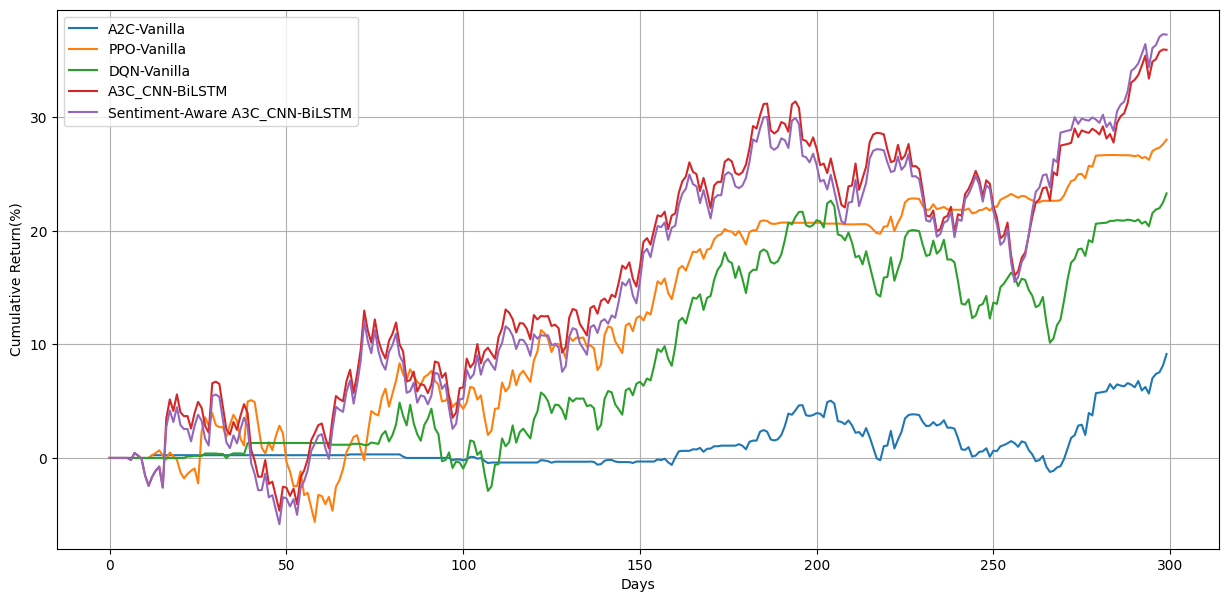

In [ ]:
plot_cumulative_returns(NASDAQ_data)

In [ ]:
file_path = 'DJIA_CR.csv'
DJIA_data = pd.read_csv(file_path)

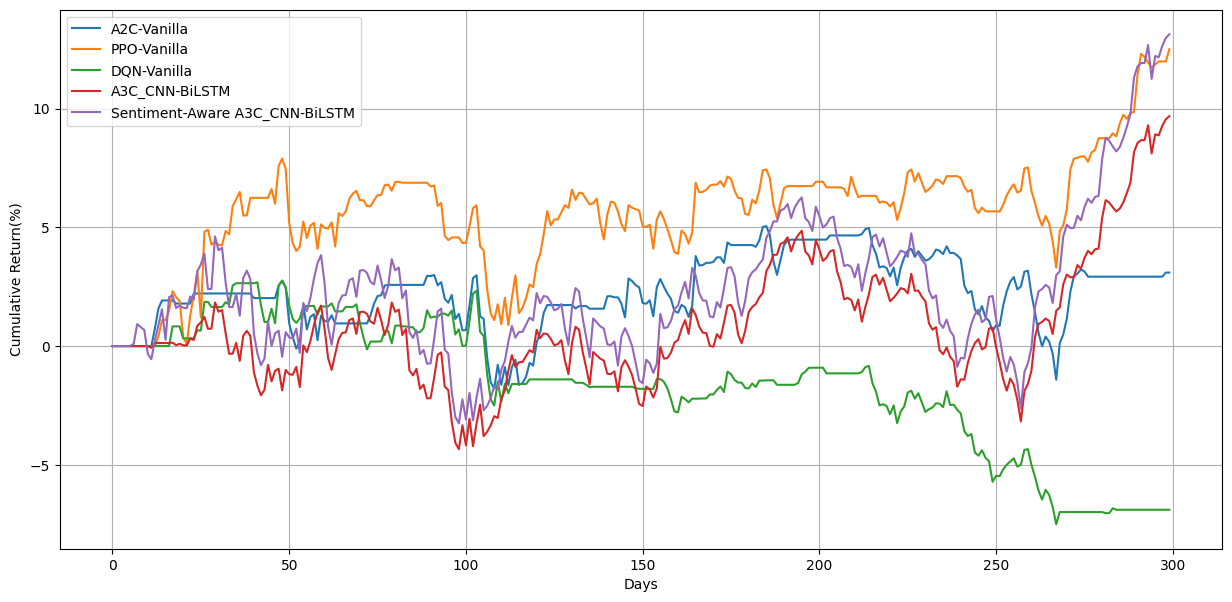

In [ ]:
plot_cumulative_returns(DJIA_data)